# AT82.08 Computer Vision Final Exam 2024

`Change the filename by inserting your student ID before submitting the file.`

# Question 1: Object Detection (10 points)
We've explored the evolution of the `R-CNN family`, encompassing `R-CNN`, `Fast R-CNN`, and `Faster R-CNN`. Analyze the key differences between these models, identifying their respective limitations and the specific challenges they were developed to overcome.

Object detection detects the objects of a certain class in the image and videos. It locates the position of the object by identifying the object's bounding box coordinates and assigns class value.

R-CNN is a two-stage object detection model that belongs to R-CNN family of models which are work in region-based principle. This method uses selective search to extract nearly 2k regions which are called regions of interest. R-CNN divides an image into regions and then classifies with localization objects within those regions. This method uses single CNN network to extract features, and generates regions dynamically based on visual content of the image.

Steps:
1. First it does image segmentation - segmenting the image into smaller regions based on color, texter size, shape, luminicty, and other features using Feizenszwalb's segmentation algorithm. These regions are called superpixels.
2. Then it applies Selective search algorithm which uses greedy algorithm to merge similar regions iteratively.
3. Then Hierarchical Grouping - generates hierarchical tree of region proposals.
4. Then again applies selective search to generate nearly 2k regions of interest.
5. Then those regions are fed into cnn feature extractor network, and those features are directed to SVM classifier to classify the precense of object. In addition to predicting the presence of an object within the region proposals, the algorithm also predicts four values which are offset values to increase the precision of the bounding box.
6. To compare boxes, R-CNN uses Intersection over Union - Jaccard similarity metric. The highest ones are selected.
7. To eliminate overlapping boxes, Non-Max Suppression (NMS) is used - but it also has problem of eliminating good boxes when objects highly overlap.
8. To evaluate object detector - it uses mean average Precision (mAP)

R-CNN predicts a transform $(t_x, t_y, t_w, t_h)$ to correct region proposal bounding box.

Problems of R-CNN:
1. It is very slow during both training and inferencing since classifying 2k region proposals per image is a time-consuming process.
2. Selective Search algorithm is a fixed algorithm which has no learning option. This could lead to the generation of bad candidate region proposals.


Fast R-CNN - deals with some drawbacks of R-CNN by making it faster object detection algorithm. It is the same algorithm, but instead of applying heuristic selective search algorithm to obtain 2k region proposals, let's first extract feature maps by feeding image into cnn network. From those feature maps, we identify the region proposals and warp them into squares, and by using ROI pooling layer we reshape them into a fixed size so that we can feed it into fully connected linear layer. From ROI feature map, we use softmax to predict the class of proposed region and also the offset values of the bounding box.

The fast keypoint here means that we do not need to feed 2k region proposals into cnn network every time, but do the convolution operation once per image to obtain feature map.

![image](./diff.png)

From the image above, fast R-CNN is significantly faster in training, but for testing including region proposals slows down the algorithm significantly when compared to not using region proposals. Therefore, region proposals become bottlenecks in Fast R-CNN algorithm affecting its performance.

Faster R-CNN. Both abovementioned methods uses selective search to find out the region proposals. Selective search is slow and time-consuming process. Faster R-CNN is the same method but without selective search algorithm instead learns the region proposals - Region Proposal Network (RPN). Similar to Fast R-CNN, the image is provided as an input to a convolutional network which provides a convolutional feature map. Instead of using selective search algorithm on the feature map to identify the region proposals, a separate network is used to predict the region proposals. The predicted region proposals are then reshaped using a RoI pooling layer which is then used to classify the image within the proposed region and predict the offset values for the bounding boxes.

Faster R-CNN is also introduced anchor boxes technique for predicting bounding boxes that was later utilized by YOLO. It is trained with 4 losses:
1. RPN classification: anchor box is object / not an object.
2. RPN regression: predict transform from anchor box to proposal box.
3. Object classification: classify proposals as background / object class.
4. Object regression: predict transform from proposal box to object box.

Faster R-CNN is two-stage detector: first stage - runs once per the image - backbone network (extract features), region proposal network (generation region proposals), and second satge - runs once per region - crop features (roi pool/align), predict object class, predict bbox offset. Two-stage detector means it is still slow for real-time detection.

![image2](./diff2.png)

But it can be seen that Faster R-CNN was a lot faster then its predecessors. Modern approaches utilize YOLO architecture, and R-CNN family was good backbone in research to come up much efficient solutions. Next method in R-CNN family is Mask R-CNN which is used for segmentation task.

---

# Question 2: GAN


## Question 2.1 (35 points)

In week 11 lecture, we learnt and implemented GAN in which the generator and discriminator were constructed with only linear layers, and trained using MNIST dataset. We observed that the quality of genereted images was not good, and needed further improvement.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) is an extension of the GAN, in which it explicitly uses `convolutional` and `convTransposed` layers in the discriminator and generator, respectively. In other words, DCGAN replaces linear layers in GAN with `conv.` layers in the discriminator, and `convTranspose` layers in the generator.

Use the following guideline to `Implement DCGAN model`:
- at least `4 conv. layers` in the `discrimimator`.
- at least `4 convTranspose layers` in the `generator`.
- latent vector `z = 100` and being sample from `normal` distribution
- Use `batchnorm` in both the generator and the discriminator.
- Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`.
- Use `LeakyReLU` activation in the discriminator for all layers.


Train the model
- `MNIST` dataset
- `25` epochs
- batch size of `128`

**`Report the following`**
- Plot both generator and discriminator `losses`.
- Show the visualization of the generated images of `every 5 epochs`

In [1]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [4]:
# Your answer here
import time
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [34]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)

channels = 1 # number of image channels (gray scale)
img_size = 28 # size of each image dimension
img_dim = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))
latent_dim = 100

# Hyperparameters

glr = 2e-4
dlr= 2e-4

NUM_EPOCHS = 25
BATCH_SIZE = 128

logging_interval = 200
save_model = True

cuda:2


In [35]:
trf = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=trf,
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [146]:
# Use the following guideline to `Implement DCGAN model`:
# - at least `4 conv. layers` in the `discrimimator`.
# - at least `4 convTranspose layers` in the `generator`.
# - latent vector `z = 100` and being sample from `normal` distribution
# - Use `batchnorm` in both the generator and the discriminator.
# - Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`.
# - Use `LeakyReLU` activation in the discriminator for all layers.

class Generator(nn.Module):
    def __init__(self, latent_dim = 100, img_dim=(1,28,28)):
        super(Generator, self).__init__()
        
        self.linear = torch.nn.Linear(latent_dim, 1024*2*2)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=2,
                stride=2, padding=2
            )
        )
        
        
        self.out = torch.nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 2, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        return self.out(x)

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*1*1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(-1, 1024*1*1)
        x = self.out(x)
        return x


In [147]:
gen = Generator(latent_dim, img_dim)
dis = Discriminator()

In [148]:
gen, dis

(Generator(
   (linear): Linear(in_features=100, out_features=4096, bias=True)
   (conv1): Sequential(
     (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv2): Sequential(
     (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv3): Sequential(
     (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
   )
   (conv4): Sequential(
     (0): ConvTranspose2d(128, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
   )
   (out): Tanh()
 ),
 Discriminator(
   (conv1): Sequential(
     (0): Conv2d(1, 128, kernel_size=

In [149]:
gen.to(device)
next(gen.parameters()).is_cuda
dis.to(device)
next(dis.parameters()).is_cuda

True

In [150]:
num_params = sum(p.numel() for p in gen.parameters())
num_trainable_params = sum(p.numel() for p in gen.parameters() if p.requires_grad)
print(f'Total num. of parametes: {num_params}')
print(f'Total num. of Trainable parametes: {num_trainable_params}')

Total num. of parametes: 11426945
Total num. of Trainable parametes: 11426945


In [151]:
adversarial_loss = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(gen.parameters(), lr=glr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=dlr, betas=(0.5, 0.999))

In [152]:
iter_ch = iter(train_loader)

items = next(iter_ch)
img = items[0].to(device)

dis(img).shape

torch.Size([128, 1])

In [153]:
z = torch.randn(batch_size, latent_dim, device=device)  # format NCHW
fake_images = gen(z)
fake_images.shape

torch.Size([128, 1, 28, 28])

In [154]:
log_dict = {'train_generator_loss_per_batch': [],
              'train_discriminator_loss_per_batch': [],
              'train_discriminator_real_acc_per_batch': [],
              'train_discriminator_fake_acc_per_batch': [],
              'images_from_noise_per_epoch': []}
# Batch of latent (noise) vectors for
# evaluating / visualizing the training progress
# of the generator
fixed_z = torch.randn(64, latent_dim, device=device) # format NCHW

start_time = time.time()
for epoch in range(NUM_EPOCHS):

    gen.train()
    dis.train()
    for batch_idx, (features, _) in enumerate(train_loader):

        batch_size = features.size(0)

        # real images
        real_images = features.to(device)
        real_labels = torch.ones(batch_size, device=device) # real label = 1

        # generated (fake) images
        z = torch.randn(batch_size, latent_dim, device=device)  # format NCHW
        fake_images = gen(z)
        fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
        flipped_fake_labels = real_labels # here, fake label = 1
        flipped_fake_labels.to(device)


        # --------------------------
        # Train Discriminator
        # --------------------------

        optimizer_D.zero_grad()

        # get discriminator loss on real images
        discr_pred_real = dis(real_images).view(-1) # Nx1 -> N
        real_loss = adversarial_loss(discr_pred_real, real_labels)

        # get discriminator loss on fake images
        discr_pred_fake = dis(fake_images.detach()).view(-1)
        fake_loss = adversarial_loss(discr_pred_fake, fake_labels)

        # combined loss
        discr_loss = 0.5*(real_loss + fake_loss)

        discr_loss.backward()
        optimizer_D.step()

        # --------------------------
        # Train Generator
        # --------------------------

        optimizer_G.zero_grad()

        # get discriminator loss on fake images with flipped labels
        discr_pred_fake = dis(fake_images).view(-1)
        gener_loss = adversarial_loss(discr_pred_fake, flipped_fake_labels)
        gener_loss.backward()

        optimizer_G.step()

        # --------------------------
        # Logging
        # --------------------------
        log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
        log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

        predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
        predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
        acc_real = (predicted_labels_real == real_labels).float().mean()*100.
        acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
        log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
        log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

        if not batch_idx % logging_interval:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                    len(train_loader), gener_loss.item(), discr_loss.item()))

    ### Save images for evaluation
    with torch.no_grad():
        fake_images = gen(fixed_z).detach().cpu()
        log_dict['images_from_noise_per_epoch'].append(make_grid(fake_images,
                                                                  padding=2,
                                                                  normalize=True))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
if save_model:
    torch.save({
          'model_state_dict': gen.state_dict(),
          'optimizer_state_dict': optimizer_G.state_dict()
          }, 'ganGen_mnist.pt')

    torch.save({
          'model_state_dict': dis.state_dict(),
          'optimizer_state_dict': optimizer_D.state_dict()
          }, 'ganDis_mnist.pt')


Epoch: 001/025 | Batch 000/469 | Gen/Dis Loss: 1.0290/0.7134
Epoch: 001/025 | Batch 200/469 | Gen/Dis Loss: 1.5514/0.2328
Epoch: 001/025 | Batch 400/469 | Gen/Dis Loss: 1.3379/0.1662
Time elapsed: 1.24 min
Epoch: 002/025 | Batch 000/469 | Gen/Dis Loss: 1.6262/0.2184
Epoch: 002/025 | Batch 200/469 | Gen/Dis Loss: 2.4409/0.0506
Epoch: 002/025 | Batch 400/469 | Gen/Dis Loss: 3.1309/0.0264
Time elapsed: 2.52 min
Epoch: 003/025 | Batch 000/469 | Gen/Dis Loss: 3.3208/0.0246
Epoch: 003/025 | Batch 200/469 | Gen/Dis Loss: 3.8317/0.0125
Epoch: 003/025 | Batch 400/469 | Gen/Dis Loss: 4.1155/0.0094
Time elapsed: 3.77 min
Epoch: 004/025 | Batch 000/469 | Gen/Dis Loss: 4.2667/0.0080
Epoch: 004/025 | Batch 200/469 | Gen/Dis Loss: 4.6334/0.0058
Epoch: 004/025 | Batch 400/469 | Gen/Dis Loss: 4.9453/0.0040
Time elapsed: 5.04 min
Epoch: 005/025 | Batch 000/469 | Gen/Dis Loss: 5.0317/0.0041
Epoch: 005/025 | Batch 200/469 | Gen/Dis Loss: 5.3171/0.0033
Epoch: 005/025 | Batch 400/469 | Gen/Dis Loss: 5.5401/

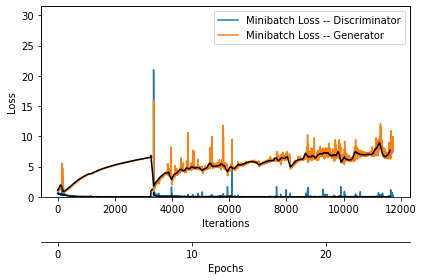

In [155]:
losses_list=(log_dict['train_discriminator_loss_per_batch'],
            log_dict['train_generator_loss_per_batch'])
custom_labels_list=(' -- Discriminator', ' -- Generator')
averaging_iterations = 100

for i,_ in enumerate(losses_list):
    if not len(losses_list[i]) == len(losses_list[0]):
        raise ValueError('All loss tensors need to have the same number of elements.')

if custom_labels_list is None:
    custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

iter_per_epoch = len(losses_list[0]) // NUM_EPOCHS

plt.figure()
ax1 = plt.subplot(1, 1, 1)

for i, minibatch_loss_tensor in enumerate(losses_list):
    ax1.plot(range(len(minibatch_loss_tensor)),
              (minibatch_loss_tensor),
              label=f'Minibatch Loss{custom_labels_list[i]}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_tensor,
                          np.ones(averaging_iterations,)/averaging_iterations,
                          mode='valid'),
              color='black')

if len(losses_list[0]) < 1000:
    num_losses = len(losses_list[0]) // 2
else:
    num_losses = 1000
maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
ax1.set_ylim([0, np.max(maxes)*1.5])
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))

newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticks(newpos[::10])
ax2.set_xticklabels(newlabel[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.tight_layout()

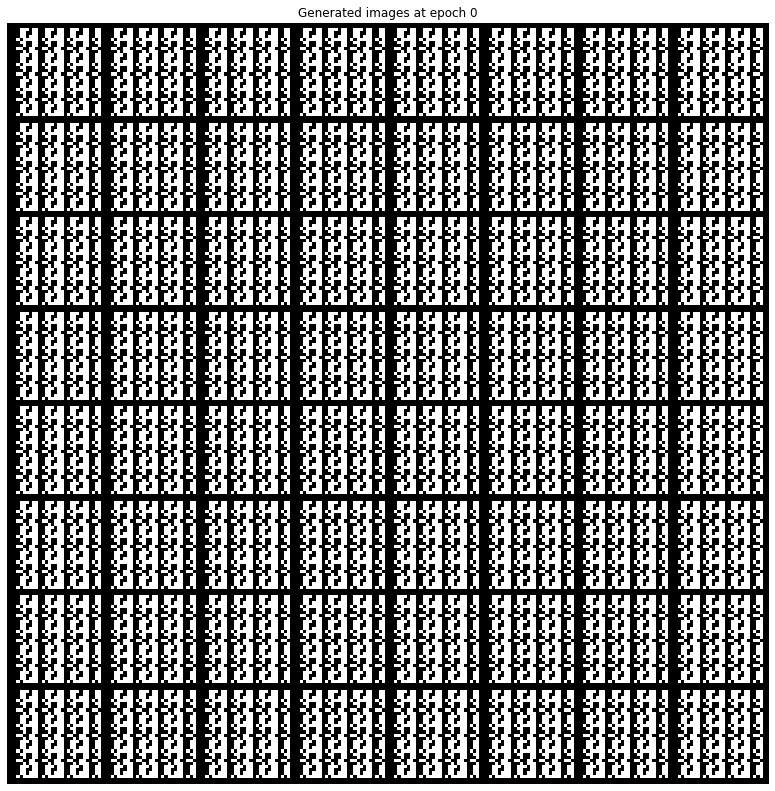

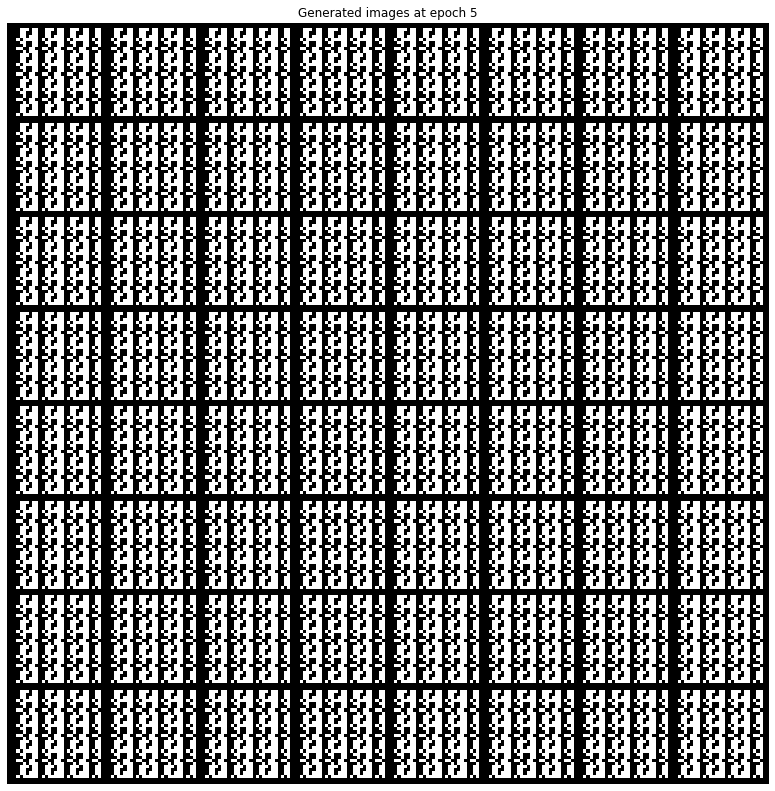

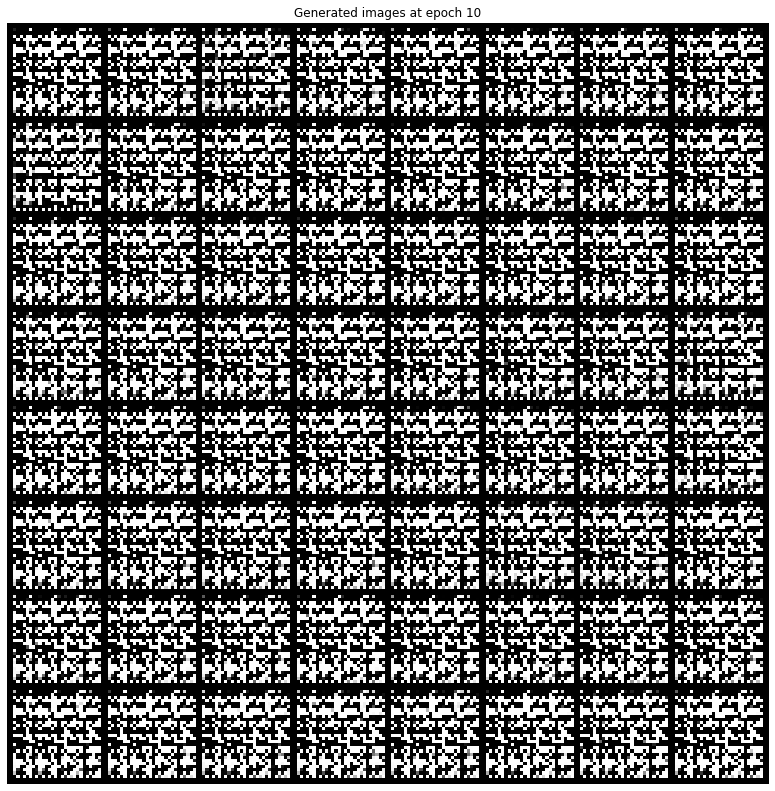

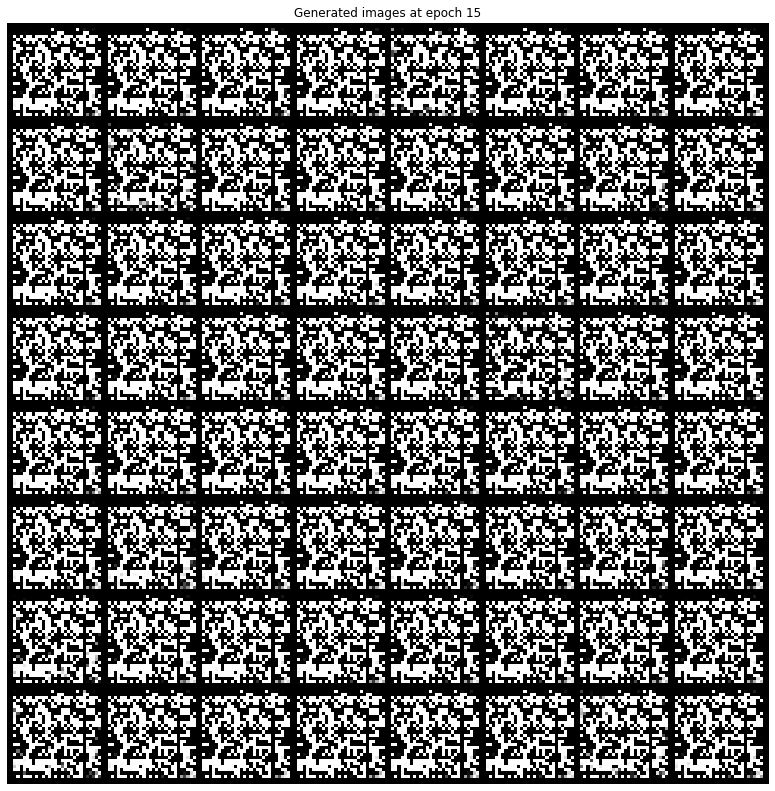

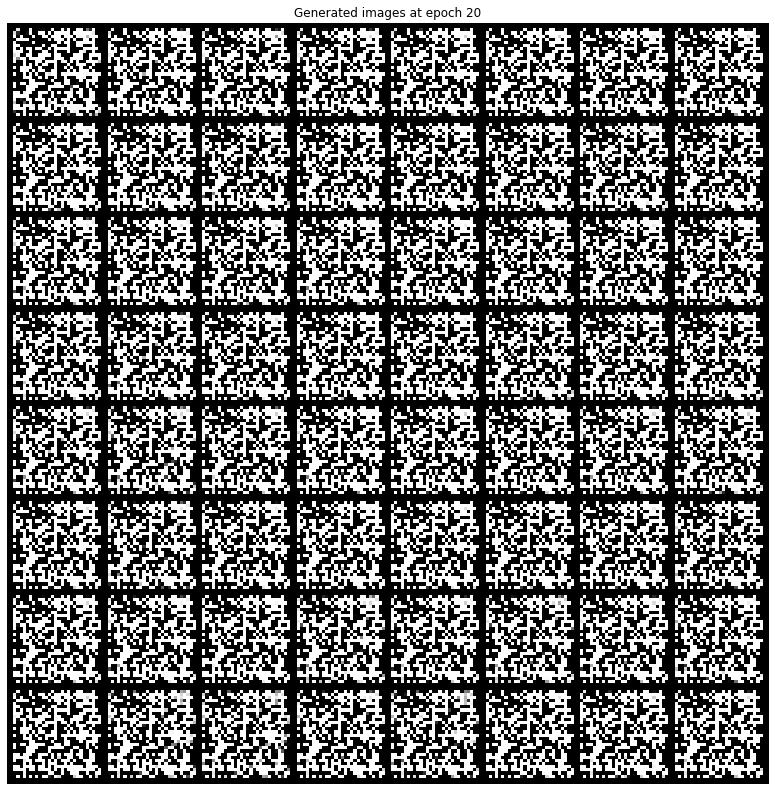

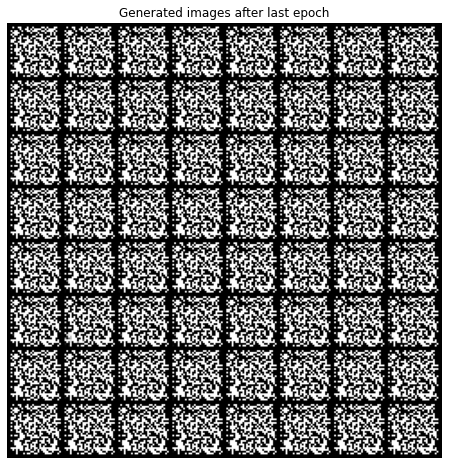

In [157]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    plt.figure(figsize=(14, 14))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

## Question 2.2 (10 points)

Recall from our GAN lab session, we implemented and trained GAN on MNIST dataset.

**Qualitative Comparison**: Conduct a comparative analysis of the image outputs generated by `GAN` and `DCGAN` models at the `25th` epoch. Determine which model produces better quality images and discuss the underlying reasons for its superior performance.

GAN at 25th epoch:

![img3gan](./gan.png)

From the trained DCGAN it is hardly observable anything notation oriented. And if we look at the loss graph, we can observe that discriminator is outperforming the generator, probably there is some issues with model configuration - no time for training over again (it is taking almost 40 minutes to train).

If we make assumption based on that example we can say that GAN is better for generating images since the visualization from gan part looks much better. But I believe, DCGAN have to be better.

# Question 3: Mean Shift (25 points)
As previously discussed, Mean Shift segmentation leverages Euclidean distance to cluster pixels in a feature space defined by pixel attributes. While we have utilized RGB color information as features, incorporating additional spatial information may enhance segmentation performance. By augmenting the feature space to include pixel coordinates (X,Y), we can apply Mean Shift to this expanded representation.


#### Implement Mean Shift segmentation using the `XYRGB` space of the given image (`q3-labrador-kmean.jpg`).
- How does the performance compare to using only the RGB color space?
- Show the center of clusters, how many clusters are there?

In [158]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import io

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

In [159]:
ms_img = cv.imread('./q3-labrador-kmean.jpg')
ms_img = cv.cvtColor(ms_img, cv.COLOR_BGR2RGB)  # (height, width, 3)
ms_img = cv.resize(ms_img, None, fx= 0.5, fy= 0.5, interpolation= cv.INTER_LINEAR)  # Resize to half
ms_img2D = ms_img.reshape((-1,3))  # (height × width, 3)
ms_img2D = np.float32(ms_img2D)

In [160]:
norm_ms_img2d= MinMaxScaler(feature_range=(0, 1)).fit_transform(ms_img2D)

In [161]:
bandwidth = estimate_bandwidth(norm_ms_img2d, quantile=.04, n_jobs=2)

In [162]:
ms_res = MeanShift(bandwidth = bandwidth, n_jobs=-1, bin_seeding=True, cluster_all=True).fit(norm_ms_img2d)

In [163]:
labels = ms_res.labels_
centers = ms_res.cluster_centers_

segmented_image = labels.reshape(ms_img.shape[:2])
segmented_image

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 6,  5,  5, ..., 13,  0,  0],
       [ 6,  5,  5, ...,  0,  0,  0],
       [ 5,  5,  6, ...,  0,  0,  0]])

In [18]:
# Example of turning nx3 (RGB) array of image pixels to nx5 (XYRGB) array of image pixels

,r,g,b,x,y
0,133,169,219,0,0
1,133,169,219,0,1
2,133,169,219,0,2
3,133,169,219,0,3
4,134,170,220,0,4
5,134,170,220,0,5
6,135,171,221,0,6
7,135,171,221,0,7
8,135,171,221,0,8
9,135,171,221,0,9


In [165]:
# Show the center of clusters, how many clusters are there?
centers.shape

(16, 3)

**Expected result**

You may get a slight different result.

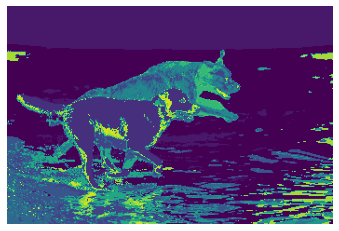

In [166]:
plt.axis('off')
plt.imshow(segmented_image)
plt.show()

# Question 4: 3D Deep Learning

## Question 4.1: (10 points)
We have discussed five 3D reprensentations used in 3D Deep learning for tasks like classification and segmentation.

- ### What are those 5 representations ? Briefly describe attributes of each representation.
- ### Analyze the advantages and disadvantages of each representation when applied to deep learning models

3D Representations:
1. Image-based
2. Volumetric
3. Point Cloud
4. Signed distance-based
5. Mesh-based

1. Image-based representation
Image-based representation combines 2D color information (RGB) with depth information (D) to give a 2.5D view of the captured 3D object.

Pros:
- Simple, re-use standard components of CNNs
- Efficient, good results

Cons:
- Memory
- Not geometric
- No invariance

2. Volumetric representation

Voxel-based models represent 3D spaces through the use of voxels, which are the three-dimensional equivalents of pixels. Each voxel contains volumetric information about a portion of the space, allowing for a comprehensive representation of both the surface and the internal structure of objects. This method is particularly useful for applications requiring a high level of detail inside objects, such as medical imaging and scientific simulations.

Pros:
- Simple

Cons:
- Coarse
- Memory
- No invariance

3. Point Cloud representation

Point Cloud is a set of points which can be represented by its coordinates (x, y, z) in 3D space. Point clouds can be seen in two ways: as unstructured sets of 3D points (non-Euclidean) or as small subsets with global coordinates and invariance to transformations (Euclidean). The choice depends on whether we focus on their global or local features. Point clouds capture precise geometric information, suitable for object recognition, 3D reconstruction, and augmented reality, but they can be memory-intensive and may lack object scene semantics.

- Point cloud is close to raw sensor data and easy to acquired by low-cost 3D scanning sensors 
- Point cloud is simple, flexible and scalable representation: only points, no connectivity.
- Point cloud is canonical

Point cloud processing pipeline: data acquisition -> registration (can be used for classification/segmentation) -> reconstruction -> Post-processing

Despite being easy to capture using technologies like Kinect and structured light scanners, processing point clouds can be challenging due to their lack of structure and ambiguity in surface information.

Pros:
- Efficient
- Simple
- Accurate

Cons:
- No Invariance

4. Signed distance-based representation

Signed distance-based representation - implicit surface representation that preserves inside-outside information of objects. It can be easily converted into visually appealing 3D mesh-based shapes 

Pros:
- Efficient
- Simple
- Accurate

Cons:
- No invariance

5. Mesh-based representation 

Mesh-based representation are structures composed of vertices, edges, and faces that define the shape of a three-dimensional object. They create a polygonal representation, often using triangles or quadrilaterals, to model complex surfaces and structures. Meshes are particularly effective for rendering detailed visualizations in computer graphics, virtual reality, and simulation applications. They provide a balance between computational efficiency and the ability to convey detailed surface properties. However, creating accurate meshes can be labor-intensive, and they may not efficiently represent objects with simple or uniform surfaces.

Learning 3D meshes is a challenge due to their irregular nature, making it difficult to apply deep learning methods directly. They often encounter noise, missing data, and resolution issues as well.

Another way to represent 3D meshes is by using graphs, where nodes represent vertices, and edges indicate connectivity. Analyzing graph spectral properties has paved the way for innovative approaches, such as defining convolution-like operations on graphs or meshes converted to graphs.

Pros:
- Efficient
- Deform. invariant
- Accurate

Cons:
- Custom layers

---

## Question 4.2: (10 points)

`PointNet` is a pioneering 3D deep learning model capable of handling point cloud data for classification and segmentation tasks. Unlike traditional image data, point clouds lack a regular grid structure and the order of points is arbitrary.

Discuss the strategies employed by PointNet to overcome these challenges and highlight its significant contributions to the field of 3D deep learning.


Key idea:  Individually (locally) process each point into a higher-dimensional feature space, then combine per-point features via an order-invariant function (e.g. max) to produce a global feature descriptor. Order invariance is key, as points in a point cloud are not ordered

- (Optionally) transform input points and intermediate vectors by a predicted matrix
- T-Net is just a smaller PointNet (without the “___ transform” blocks)
- Intuition: learned, input-dependent transform may help ‘canonicalize’ the data
- Empirically leads to slightly better performance

Local Embedding:
- Can be used for segmentation (or other local analysis tasks) with a slight tweak
- Concat global feature to each point feature → independent processing
- Intuition: global feature makes point processing “context-aware”

PointNet saves 80% memory compared to volumetric approach (Subvolume), and the computation time is also decreased

Limitations of PointNet:
- No local context for each point
- Global feature depends on absolute coordinate. Hard to generalize to unseen scene configurations.

PointNet uses the following strategies:

- Permutation Invariance: PointNet ensures that the network's output is invariant to the order of the input points. This is achieved by using a symmetric function, specifically max pooling, which aggregates features from all points in a way that is independent of their order.

- Learning Global and Local Features: PointNet processes each point independently in the initial layers to learn local features. These features are then aggregated using max pooling to capture global information about the entire point cloud.

- Spatial Transformer Network: To handle variations in the spatial arrangement of points, PointNet incorporates a spatial transformer network. This module learns to canonicalize the input point cloud, making the model more robust to geometric transformations.

Its contribution to 3D deep learning:
- Direct Processing of Point Clouds: Unlike previous methods that convert point clouds into regular 3D voxel grids or collections of images, PointNet directly processes raw point cloud data. This avoids the computational overhead and potential information loss associated with such conversions.

- Unified Architecture: PointNet provides a unified framework for various 3D recognition tasks, including object classification, part segmentation, and scene semantic parsing. This versatility has made it a foundational model in the field.

- Efficiency and Effectiveness: Despite its simplicity, PointNet has demonstrated strong performance on par with or even surpassing state-of-the-art methods at the time of its introduction. Its efficiency and effectiveness have paved the way for further advancements in 3D deep learning.

PointNet had a profound impact on the field of 3D deep learning, setting the stage for subsequent models and research (PointNet++, Dynamic graph and etc.).

---